# **Sentiment Analysis TheBridge**

In [ ]:
import tweepy as tw
import snscrape.modules.twitter as sntwitter
import pandas as pd
import sqlite3
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

## Caso de uso

Nuestro cliente (@TheBridge_Tech) desea desarrollar una monitorización de las redes sociales para medir el impacto de su marca y acciones comerciales.

Para cumplir con su objetivo procedemos a realizar una serie de tareas desarrolladas a continuación.

### Recopilación de tweets mediante API

Para llevar a cabo la tarea de recopilar tweets referentes a TheBridge con el fin de saber el sentimiento general hacia la compañía en esta red social (twitter) inicialmente utilizamos la API de twitter, desde la que procedemos a descargar la información.

In [2]:
# Credenciales
MY_BEARER_TOKEN = "XXXXXXX"

# Cliente
client = tw.Client(bearer_token=MY_BEARER_TOKEN)

In [3]:
# Petición
query = "@TheBridge_Tech lang:es -is:retweet"
# Parámetros (Debido a limitante de API de Twitter, se menciona más adelante)
start_time = "2022-05-17T00:00:00Z"
end_time = "2022-05-22T00:00:00Z"
# Obtener tweets
tweets = client.search_recent_tweets(query=query,
                                     start_time=start_time,
                                     end_time=end_time,
                                     tweet_fields = ["created_at", "text", "source"],
                                     user_fields = ["name", "username", "location", "verified", "description"],
                                     max_results = 100,
                                     expansions='author_id'
                                     )

In [6]:
# Creamos un dataset
tweets_info = []
# Iterando sobre los tweets
for tweet, user in zip(tweets.data, tweets.includes['users']):
    tweet_info = {
        'Fecha_Creacion': tweet.created_at,
        'Texto': tweet.text,
        'Fuente': tweet.source,
        'Nombre': user.name,
        'Username': user.username,
        'Ubicación': user.location,
        'Verificado': user.verified,
        'Descripcion': user.description
    }
    tweets_info.append(tweet_info)
# Creamos dataframe
tweets_df = pd.DataFrame(tweets_info)
# Observamos dataframe
tweets_df.head()

,Fecha_Creacion,Texto,Fuente,Nombre,Username,Ubicación,Verificado,Descripcion
0,2022-05-18 15:23:22+00:00,Esta es la historia de Isis🤗 que decidió hacer...,Twitter Web App,The Bridge,TheBridge_Tech,"Paseo de Recoletos, 15, Madrid",False,Aceleradora de Talento Digital\n\nBootcamps | ...
1,2022-05-18 11:26:31+00:00,Gracias @victorianoI y equipo por el análisis ...,Twitter Web App,Bcas,Bcasapp,Spain,False,¡¡Consigue dinero!! Adelantos de becas con Wal...
2,2022-05-18 08:31:13+00:00,¿Cómo combatir el paro juvenil🥵? #tipdeldia En...,Twitter Web App,Periódico PublicidAD,PdelaPublicidad,"Madrid, Spain",False,Te ofrecemos toda la información sobre el sect...


### Usando webscrapping

La API de Twitter tiene una limitación y exige que para obtener información de tweets de hace más de una semana (7 dias) se debe tener una cuenta con un estatus mas alto (académica), por lo que procedemos a aplicar webscrapping.

In [ ]:
import twit_scrap #Creamos un .csv con los datos deseados llamado "tweets.csv"

In [10]:
df = pd.read_csv("tweets.csv", index_col=0)#Dataframe con los datos completos
df

,Date,User,Tweet,Likes,Retweets,Replies
0,2022-05-19 15:39:16+00:00,TheBridge_Tech,¡Qué poco queda para el próximo 🔥Burn Monday🔥!...,0,2,0
1,2022-05-18 15:23:22+00:00,TheBridge_Tech,Esta es la historia de Isis🤗 que decidió hacer...,0,0,0
2,2022-05-18 11:26:31+00:00,TheBridge_Tech,Gracias @victorianoI y equipo por el análisis ...,0,0,0
3,2022-05-18 08:31:13+00:00,Bcasapp,¿Cómo combatir el paro juvenil🥵? #tipdeldia En...,8,4,1
4,2022-05-17 14:53:47+00:00,TheBridge_Tech,¿Con ganas de probar si un empleo tecnológico ...,2,2,0
...,...,...,...,...,...,...
129,2022-01-18 16:02:13+00:00,TheBridge_Tech,Del periodismo al marketing digital 🤸 esta es ...,0,0,0
130,2022-01-12 19:03:03+00:00,nodosenlared,Ciclo de Conferencias sobre Inteligencia Artif...,6,1,0
131,2022-01-09 17:23:02+00:00,ing_titiritero,Me encantaría saber que les enseñan sobre esta...,0,0,0
132,2022-01-08 12:10:46+00:00,cmarchena,"@cbusquets Hola, @TheBridge_Tech te da la opci...",4,0,0


### Generando base de datos

Procedemos a generar una base de datos SQL para almacenar información futura.

In [19]:
#Dataframes para generar dos tablas en la base de datos
df_1 = df[["Date", "User", "Tweet"]]
df_2 = df[["Likes", "Retweets", "Replies"]]

#Generando base de datos
conn = sqlite3.connect('twitter_tb_db') #Se genera la base de datos llamada twitter_tb_db
c = conn.cursor() #Se coloca el cursor

c.execute('CREATE TABLE IF NOT EXISTS str_data (Date text, User text, Tweet text)') #Se crea la tabla "str_data" en la base de datos
conn.commit()                                                                        #con tres columnas (Date,User,Tweet), todas tipo texto

c.execute('CREATE TABLE IF NOT EXISTS num_data (Likes number, Retweets number, Replies number)') #Se crea la tabla num_data igual a la
conn.commit()                                                                                      #anterior

df_1.to_sql('str_data', conn, if_exists='replace', index = False) #Si ya existe la columna que la reemplace

df_2.to_sql('num_data', conn, if_exists='replace', index = False)

### Análisis de datos

Nos planteamos distintas preguntas a ser respondidas con data, a petición de nuestro cliente.

In [ ]:
##Dejo la fecha en un formato que luego puedo cambiar a datetime tomando solo el día, mes y año [0:10]
for i,j in enumerate(df["Date"]):
    df["Date"].iloc[i] = df["Date"][i][0:10]

df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d")

#### Tweets con más impacto social

In [13]:
#Tweets con mas impacto social
df["Social impact"] = df["Likes"] + df["Retweets"] + df["Replies"] #Digo que el impacto es igual a la sumatoria de likes+retweets+rep
df[df["Social impact"] > 10] #Cuales son las de mayor impacto (Mayor de 10, puedo seleccionar las 3 que mas tienen)

,Date,User,Tweet,Likes,Retweets,Replies,Social impact
3,2022-05-18,Bcasapp,¿Cómo combatir el paro juvenil🥵? #tipdeldia En...,8,4,1,13
19,2022-04-28,JM_Torralba_,En breve empezamos la charla sobre RV y Psicol...,15,1,0,16
25,2022-04-26,kairos_ds,"Nuestra Head de Data &amp; IA @quierodata, est...",7,5,0,12
55,2022-04-18,bertinha84,Hoy empiezo en un ratito mi camino en el Ux/ui...,6,1,5,12
57,2022-04-12,manufosela,"De los 21, hay 7 desarrolladoras de @Adalab_Di...",12,3,3,18
74,2022-03-24,ENCamaraSevilla,La @camaradesevilla organiza junto al Grupo Pl...,7,4,0,11
88,2022-03-05,pablooliete,Día para agradecer a @TheBridge_Tech y @Glovo_...,13,0,0,13
104,2022-02-18,IndraCompany,¿Aún no has solicitado tu beca para el #bootca...,8,5,0,13


<AxesSubplot:xlabel='Likes', ylabel='Social impact'>

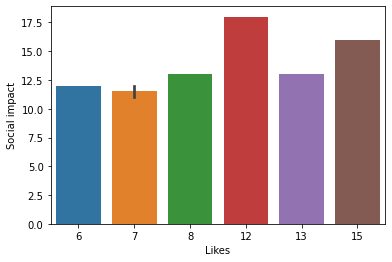

In [41]:
plot_data = df[df["Social impact"] > 10][["Likes", "Social impact"]]
sns.barplot(x=plot_data["Likes"], y=plot_data["Social impact"])

#### Usuario que más menciona a TheBridge

In [45]:
#Usuario que mas menciona a TheBridge
df["User"].value_counts()

TheBridge_Tech     53
MujeresaSeguir      7
bertinha84          5
FUniversia          3
IndraCompany        3
soyelsimo           2
arey                2
nodosenlared        2
burn_es             2
Poder_Liderazgo     2
vocentoeventos      2
JM_Torralba_        2
CourseReport        2
TheFringeLABS       2
michaelpage_es      1
PICKYUAN            1
MyNews_es           1
carlosguardiola     1
ENCamaraSevilla     1
insidezeusdata      1
pablooliete         1
cmarchena           1
Women4Cyber_SP      1
soyuxpuntocom       1
antoniolopezg       1
zoomtecnochile      1
camaradesevilla     1
pumuckey            1
SoyValor            1
AssociacioACEC      1
diegodl             1
ing_titiritero      1
AIBot_CdH           1
raulcotrina         1
assemblerinstit     1
Capgemini_ES        1
PdelaPublicidad     1
Alberto_Blanco      1
graphext            1
apedreroes          1
spaingeneration     1
gabinha             1
IrnMM               1
kairos_ds           1
BerrocalRuben       1
COGITIVale

El usuario que más menciona a TheBridge es MujeresaSeguir.

#### Meses con mayor actividad

In [16]:
#Meses con mas actividad
df["Month"] = df["Date"].dt.strftime('%m')
df["Month"].value_counts()

04    49
03    27
02    23
05    18
01    17
Name: Month, dtype: int64

El més de abril (04) tiene mayor actividad.

#### Correlación de métricas

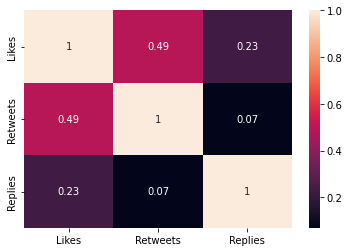

In [20]:
sns.heatmap(df_2.corr(), annot = True);

La mayor correlación está entre likes y retweets, con 0.49.

#### Modelo preentrenado

Realizamos la predicción de "sentimientos" en los tweets con un modelo preentrenado de NLP.

In [21]:
#Limpiando un poco la data de los textos de tweets para las predicciones

# Remover todos los signos de puntuación, exclamaciones...
# Tb pasamos a minuscula y nos cargamos etiquetas HTML
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    # Para todas las reviews en minuscula, sustituye algunas cosas por espacio y otras por vacio.
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

# Reviews tras aplicar la limpieza
tweets_clean = preprocess_reviews(df["Tweet"])

In [22]:
df["Clean Tweet"] = tweets_clean #Columna de tweets en clean

In [23]:
df

,Date,User,Tweet,Likes,Retweets,Replies,Social impact,Month,Clean Tweet
0,2022-05-19,TheBridge_Tech,¡Qué poco queda para el próximo 🔥Burn Monday🔥!...,0,2,0,2,05,¡qué poco queda para el próximo 🔥burn monday🔥 ...
1,2022-05-18,TheBridge_Tech,Esta es la historia de Isis🤗 que decidió hacer...,0,0,0,0,05,esta es la historia de isis🤗 que decidió hacer...
2,2022-05-18,TheBridge_Tech,Gracias @victorianoI y equipo por el análisis ...,0,0,0,0,05,gracias @victorianoi y equipo por el análisis ...
3,2022-05-18,Bcasapp,¿Cómo combatir el paro juvenil🥵? #tipdeldia En...,8,4,1,13,05,¿cómo combatir el paro juvenil🥵 #tipdeldia en ...
4,2022-05-17,TheBridge_Tech,¿Con ganas de probar si un empleo tecnológico ...,2,2,0,4,05,¿con ganas de probar si un empleo tecnológico ...
...,...,...,...,...,...,...,...,...,...
129,2022-01-18,TheBridge_Tech,Del periodismo al marketing digital 🤸 esta es ...,0,0,0,0,01,del periodismo al marketing digital 🤸 esta es ...
130,2022-01-12,nodosenlared,Ciclo de Conferencias sobre Inteligencia Artif...,6,1,0,7,01,ciclo de conferencias sobre inteligencia artif...
131,2022-01-09,ing_titiritero,Me encantaría saber que les enseñan sobre esta...,0,0,0,0,01,me encantaría saber que les enseñan sobre esta...
132,2022-01-08,cmarchena,"@cbusquets Hola, @TheBridge_Tech te da la opci...",4,0,0,4,01,@cbusquets hola @thebridge_tech te da la opció...


In [25]:
#Predicciones
prediccion_modelo_1 = ["De los 21, hay 7 desarrolladoras de Adalab_Digital, 4 de 4GeeksAcademyES, 2 de CodenotchMAD, 1 de socratech_ , 1 de TheBridge_Tech, 1 de @ITAcademy, 1 de nebulova_es y de FP-DAW y autodidactas."]
prediccion_modelo_2 = [df["Clean Tweet"].iloc[19]] #Esto para no copiar todo el texto como en la de arriba
prediccion_modelo_3 = [df["Clean Tweet"].iloc[88]]
pickled_model = pickle.load(open('finished_model.model', 'rb')) #Finished model que nos habían dado
prediccion_1 = pickled_model.predict(prediccion_modelo_1)
prediccion_2 = pickled_model.predict(prediccion_modelo_2)
prediccion_3 = pickled_model.predict(prediccion_modelo_3)

print(prediccion_1) #Predicciones
print(prediccion_2)
print(prediccion_3)

[0]
[1]
[1]


#### Analizando resultados

In [26]:
print("Tweet 1: ", prediccion_modelo_1, "\n")
print("Tweet 2: ", prediccion_modelo_2, "\n")
print("Tweet 3: ", prediccion_modelo_3)

Tweet 1:  ['De los 21, hay 7 desarrolladoras de Adalab_Digital, 4 de 4GeeksAcademyES, 2 de CodenotchMAD, 1 de socratech_ , 1 de TheBridge_Tech, 1 de @ITAcademy, 1 de nebulova_es y de FP-DAW y autodidactas.'] 

Tweet 2:  ['en breve empezamos la charla sobre rv y psicología todo ready @thebridge_tech https  tco lwfvkhcgz'] 

Tweet 3:  ['día para agradecer a @thebridge_tech y @glovo_es la oportunidad que han dado a estos dos cracks para formarse con @codeorg en programación por bloques en un curso de  horas de duración\nbravo 🙌 \n🔝🦸🏻\u200d♂️🦸🏻\u200d♀️🏭🇪🇸 https  tco ztcrrohqtc']


La segunda y tercera predicción arrojan resultados negativo, lo cual no es correcto, esto puede deberse a la presencia de símbolos o el entrenamiento con una data distinta.

Se observa que en los otros dos se encuentran links que pueden estar afectando el resultado.

El modelo es mejorable entrenando con las palabras comunes a esta empresa, limpiando mejor texto de simbolos, emojis y links.

Otros modelos de ML pueden ser aplicados para observar el cambio en el tiempo y si es sostenido (Time Series).

#### Despliegue de modelo

El modelo se encuentra desplegado en el siguiente link: http://miguellc.pythonanywhere.com/ (Descripción en api_calls)

Es posible desplegarlo en AWS para aprovechamiento de un servidor más robusto.